# Project Overview

# ![Overview](images/presentation_assets/Overview.png)     

The goal of this project is to develop a convolutional neural network (CNN) designed to view images of chest x-ray scans and classify the images as showing symptoms of pneumonia (a label of '0') or not (a label of '1'). If succesful, the resulting model would be used to assist medical professionals by expediting the diagnostic process. This project aims to develop an AI that would power a software tool that could be added to the medical proffesionals tool bag and help make diagnosing Pneumonia easier and faster. This would benefit both the medical providers and patients by reducing man-hours per diagnosis thereby reducing overall costs. This AI model is being developed independently by myself with the goal of being absorbed by a larger relevent medical service busines. Once the model is ready for beta testing, the next step will be to pitch the product to stake holders of interested businesses who would have the resources develop an industry grade UI for the product and robust UX research.  

# ![Business Use Case](images/presentation_assets/Business%20Use%20Case.png)  

Pneumonia is an infection of the lung that is quite prominent in the US today despite having some of the best medical care available. Pneumonia is the leading cause of death worldwide for children under 5 and is the most common cause for hospital admissions in the US, save for pregnancy<sup>[1](https://www.thoracic.org/patients/patient-resources/resources/top-pneumonia-facts.pdf)</sup>.  

It is clear that there is much room for innovation in the way we handle the scourge Pneumonia, however the medical care *system* is notoriously complex and slow to adapt to the rapidly evolving technological landscape. Instead of reinventing the wheel, it is best to leverage extant industry technology and processees that capture Pneumonia among other diseases. Due to the ubiquitious use of x-ray technology around pneumonia and other diseases of the chest and torso, a wealth of image data is available that demonstrates quality examples of both healthy (or at least without pneumonia) respiratory tracts and those, in fact, with pneumonia.  

A computer vision based machine learning model (ML), once properly trained and optimized, could easily be folded into the afformentioned existing technology. By partnering with the software providers behind the existing technology used to capture, view and store x-ray data. Said ML could easily be incorporated into the software and its *prediction* be provided to the medical profesional at their discretion. So long as clear and concise documentation is provided to the medical profesionals regarding how best to utilize and interpret this new AI feature of their pre-existing software this could potentially expedite the diagnostic timeline and provide the care provider with greater confidence in their own diagnoses.

In other words, the business goal of this project is to be absorbed by an existing software provider that can integrate this AI model as the underlying engine for a new tool and/or feature in their existing, deployed software. The benefit to said software provider is to circumvent the AI development process and focus on areas they are already expert at such as UI/UX, backend, database, etc. This allows the software provider to further improve their product, without pioneering into totally new territory; likewise allows myself as a datascientist to make a meaningful and profitable impact without the cost of learning or hiring for a litany of adjacent skill sets.

# Exploratory Data Analysis and Preprocessing

# ![Data Source](images/presentation_assets/Data%20Overview.png)
This project utilizes a dataset of 5856 jpeg images of chest x-ray scans from patient's at the Guangzchou Women's and Children's Medical Center in China.  

This dataset originally comes from [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) and it was directly sourced for this project from Paul Mooney on [Kaggle.com](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) using the Kaggle API on the command line. The original kaggle post describes the dataset as follows:  

> The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Data loading and summary

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

# dictionary of volume of data per class per sample
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"NORMAL")),len(os.listdir(train_dir+"PNEUMONIA")),len(os.listdir(train_dir+"NORMAL"))+len(os.listdir(train_dir+"PNEUMONIA"))],
    "Test Sample":[len(os.listdir(test_dir+"NORMAL")),len(os.listdir(test_dir+"PNEUMONIA")),len(os.listdir(test_dir+"NORMAL"))+len(os.listdir(test_dir+"PNEUMONIA"))],
    "Val Sample":[len(os.listdir(val_dir+"NORMAL")),len(os.listdir(val_dir+"PNEUMONIA")),len(os.listdir(val_dir+"NORMAL"))+len(os.listdir(val_dir+"PNEUMONIA"))]
}

# class balance dictionary as a dataframe with row index representing class and column index representing sample
class_balance_df = pd.DataFrame(class_balance_dict,index=['Normal', 'Pneumonia','Total'])
class_balance_df

,Train Sample,Test Sample,Val Sample
Normal,1341,234,8
Pneumonia,3875,390,8
Total,5216,624,16


The data comes already labeled and split for 3 way validation. The Train sample is, naturally, the largest of the 3 with over five thousand images, 66% of which are cases of pneumonia which will be the target prediction. The next largest is the test sample with over six hundred images of which 40% are trues cases of pneumonia. Finally, the validation set contains 16 images with each class being represented equally at 50%.  

### Visualization of Class Balance and Volume

Shows the class balance of each sample with the total volume per sample being normalized.

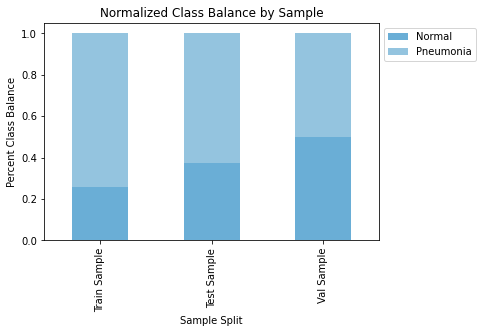

In [3]:
# Create colors
blues = plt.cm.Blues

# normalize data as percentage and rotate for plotting
class_balance_normalized = class_balance_df.iloc[:-1,:].T.apply(lambda x: x/x.sum(), axis=1)
 
# create stacked bar chart for students DataFrame
class_balance_normalized.plot(kind='bar', stacked=True, color=[blues(0.5), blues(0.4)])

# Add Title and Labels
plt.title('Normalized Class Balance by Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Balance')

plt.legend(bbox_to_anchor=(1, 1))


plt.show()

Shows the class balance per sample along with the total volume per sample

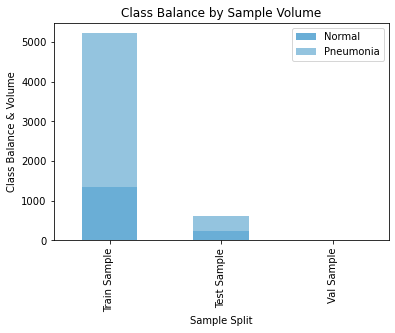

In [4]:
# Create colors
blues = plt.cm.Blues

# create stacked bar chart for students DataFrame
class_balance_df.iloc[:-1,:].T.plot(kind='bar', stacked=True, color=[blues(0.5), blues(0.4)])

# Add Title and Labels
plt.title('Class Balance by Sample Volume')
plt.xlabel('Sample Split')
plt.ylabel('Class Balance & Volume')

plt.show()

Same information as above but visualied as a pie chart to make the validation sample readable (sort of).

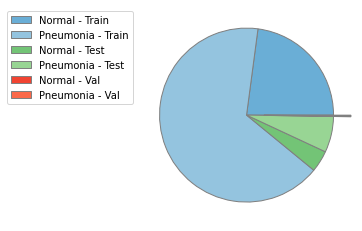

In [5]:
# prepare data to plot
subgroup_size = list(class_balance_df.iloc[:-1,0])+list(class_balance_df.iloc[:-1,1])+list(class_balance_df.iloc[:-1,2])
 
# Create colors
a, b, c = [plt.cm.Blues, plt.cm.Greens, plt.cm.Reds]
pie_colors = [a(0.5), a(0.4), b(0.5), b(0.4), c(0.6), c(0.5)]

# explode for readibility
pie_explode = [0, 0, 0, 0, .2, .2]

# plot the pie
fig, ax = plt.subplots()
 
pie, _ = ax.pie(subgroup_size, radius=1, explode=pie_explode, colors=pie_colors)
plt.setp(pie, width=1, edgecolor='gray')
plt.margins(0,0)

# Create a legend with a list of labels
labels = ['Normal - Train', 'Pneumonia - Train', 'Normal - Test','Pneumonia - Test','Normal - Val','Pneumonia - Val']
plt.legend(labels=labels, bbox_to_anchor=(0, 1))
 
# show it
plt.show()

### Sanity Check: Can the images be displayed easily?

In [6]:
from PIL import Image

# an example of (first) and Normal x-ray scan and (second) and x-ray scan showing pneumonia
Image.open("data/train/NORMAL/IM-0115-0001.jpeg").show()
Image.open("data/train/PNEUMONIA/person1001_bacteria_2932.jpeg").show()

## Formating Data for Modeling

# ![Data Preparation](images/presentation_assets/Data%20Prep.png)

As shown above the data comes already split into three distinct samples (train, test, and validate). Additionaly the originators of the data have already performed quality controlled binary class labeling by qualified professionals. There was no use of resampling methods throughout this project due to the sufficient volume of data (i.e. even the minority class is composed of several thousand data points). Therefore the only data preparations steps left are to prepare the image files to be "readable" to a Keras CNN, to achieve this I will be using the Keras  [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with its related flow_from_directory() method to read the jpg files found in the data folder into the generator objects. Upon instantiation of the generator objects the data will be normalized so that all first order tensors (a single pixel value) are scaled 0-1 instead of 0-255 (standard pixel values), and is set to grayscale so that each image is represented by a two dimensional tensor with a single color channel instead of three.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


One key advantage to utilizing the ImageDataGenerator class is that it allows the X and y data to be readable by other Keras function and methods with a single variable. The generator objects all share the same parameters; the color mode is set to grayscale, reducing unnecessary volume and complexity of the input data, the class mode is set to binary, reflecting the binary classification requirements of this project, images are resized to 150 by 150 pixels, and the batch size was originally 16 but then reduced to 8 as it appeared to improve the models ability to learn. 

## Data Modeling Methods
For this project I will be using the Keras Python API to build a convolutional neural network. This is a class of model that is typically used for binary image classification so it will be well suited for this projects needs and goals.  

The actual model protyping and development will be performed throughout the following [Modeling notebook](modeling.ipynb). Below is a meant to check a) if the data is formatted correctly to be readible by a CNN using the above preprocessing methods and b) protype the evaluation methods that will be used to analyze and diagnose model performance throughout iterations.

In [26]:
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall

In [27]:
# build a simple convultional neural network
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(1, activation='sigmoid'))

# compile model from above
base_model.compile(loss='binary_crossentropy',metrics=['acc',Recall()])

In [29]:
# fit the model to the training data and validate with the test sample
base_model_results = base_model.fit(train_data_generator, 
                    batch_size=16,
                    epochs=10,
                    steps_per_epoch=25,
                    validation_data=test_data_generator,
                    validation_steps=15
                    )

Epoch 1/10
25/25 [==============================] - 8s 330ms/step - loss: 1.2186 - acc: 0.6900 - recall: 0.8040 - val_loss: 0.7230 - val_acc: 0.5417 - val_recall: 0.2810
Epoch 2/10
25/25 [==============================] - 8s 318ms/step - loss: 0.4711 - acc: 0.7825 - recall: 0.8912 - val_loss: 0.4341 - val_acc: 0.7917 - val_recall: 0.9306
Epoch 3/10
25/25 [==============================] - 8s 325ms/step - loss: 0.3600 - acc: 0.8575 - recall: 0.9433 - val_loss: 0.6602 - val_acc: 0.6458 - val_recall: 1.0000
Epoch 4/10
25/25 [==============================] - 8s 310ms/step - loss: 0.2719 - acc: 0.8850 - recall: 0.9466 - val_loss: 0.2830 - val_acc: 0.9167 - val_recall: 0.9346
Epoch 5/10
25/25 [==============================] - 8s 316ms/step - loss: 0.2528 - acc: 0.9175 - recall: 0.9516 - val_loss: 0.4068 - val_acc: 0.7667 - val_recall: 0.9806
Epoch 6/10
25/25 [==============================] - 8s 314ms/step - loss: 0.1966 - acc: 0.9250 - recall: 0.9607 - val_loss: 0.6925 - val_acc: 0.6958 -

## Model Evaluation Methods
Because the intended us of this AI being developed is intended to be used in a medical diagnostic setting. I will be priortizing improving perforance in regard to recall and F1-score with some tolerance for false positves (i.e. normal labeled as pneumonia) and a low tolerance for false negatives (i.e. pneumonia labeled as normal).  

Below I will develop several functions that will be used to mine performance statistics on the models classification ability and visualize those values in a sensical way. These functions will relay primarily on numpy and sklearn (metrics module) to calculate the values needed. Pandas to format some of the data, and matplotlib to render the visualizations. 

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

### Mining classification performance statistics
The following functions calculates and returns and set of highly useful key performance indicators (KPIs).

In [44]:
def evaluate_model_performance(model,data_generator):
    """
    Takes in a keras model object and ImageDataGenerator object
    Converts dataset from generator into a 3D numpy array
    Calcultes key performance indicators (KPIs) 
    Returns recall and loss (tuple of floats), classification report, a confusion matrix (2d array), and the prediction and test labels (tuple of 1d arrays)
    """
    
    # declare X and y data arrays
    batch_count = len(data_generator)

    X_test_arr, y_test_arr = data_generator[0]

    for i in range(batch_count):
        X_batch, y_batch = data_generator[i]

        X_test_arr = np.concatenate((X_test_arr,X_batch),axis=0)
        y_test_arr = np.concatenate((y_test_arr,y_batch),axis=0)

    # insantiate test prediction
    y_pred = np.round(model.predict(X_test_arr))

    # evaluate KPIs
    loss, accuracy, recall = model.evaluate(X_test_arr,y_test_arr)

    # calculate the confusion matrix and classification report
    matrix = confusion_matrix(y_test_arr, y_pred)
    report = classification_report(y_test_arr,y_pred)
    
    print("Done!")
    return (np.round(recall,4), np.round(loss,2)), report, matrix, (y_pred, y_test_arr)


In [45]:
(base_model_recall, base_model_loss), base_model_report, base_model_matrix, (y_pred, y_test) = evaluate_model_performance(base_model,test_data_generator) 

20/20 [==============================] - 1s 57ms/step - loss: 0.8885 - acc: 0.7063 - recall: 0.9975
Done!


In [46]:
print("model loss: ",base_model_loss)
print("model recall: ",base_model_recall)
print("\nclassification report: \n",base_model_report)
print("\nconfusion matrix: ")
base_model_matrix

model loss:  0.89
model recall:  0.9975

classification report: 
               precision    recall  f1-score   support

         0.0       0.98      0.22      0.36       240
         1.0       0.68      1.00      0.81       400

    accuracy                           0.71       640
   macro avg       0.83      0.61      0.58       640
weighted avg       0.79      0.71      0.64       640


confusion matrix: 


array([[ 53, 187],
       [  1, 399]], dtype=int64)

### Visualize model training history

In [80]:
# visualizes accuracy and loss accross training epochs
def visualize_training_history(model_history,recall_num:None):
    """ 
    Visualizes the model's accuracy, loss, and recall as it evolves through training epochs.
    Training data is represented as a dot plot while test data is visualized as a line plot
    Takes two positional arguments:
        - a model history object 
        - a suffix generated by keras as a string (i.e. "_int")
            running this notebook sequentially without rerunning cells where models are compiled should allow for cells wher this function
            is called to be run as is. However if there is an error, check that this parameter is the same suffix as that used in the verbose
            print out from the cell where the relevant model is trained (i.e. some_model_results = some_model.fit()). This suffix is contained
            in memory and is an artifact of what order the model was compiled relative to the others in the active kernal, meaning if the kernal 
            is reset, so are these suffixes.     
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    recall = model_history.history['recall'+recall_num]
    val_recall = model_history.history['val_recall'+recall_num]
    epochs = range(len(acc))

    # Create subplots with 1 row and 3 columns
    fig, (ax3, ax2, ax1) = plt.subplots(1, 3, figsize=(16,4))

    # Adjust the spacing between the plots
    plt.subplots_adjust(wspace=.1)

    # Plot the recall
    ax3.plot(epochs, recall, 'bo', label='Training recall')
    ax3.plot(epochs, val_recall, 'b', label='Test recall')
    ax3.set_title('Training and Test recall')
    ax3.legend()

    # Plot the loss
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Test loss')
    ax2.set_title('Training and Test loss')
    ax2.legend()

    # Plot the accuracy
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.legend()

    # Show the plots
    plt.show()

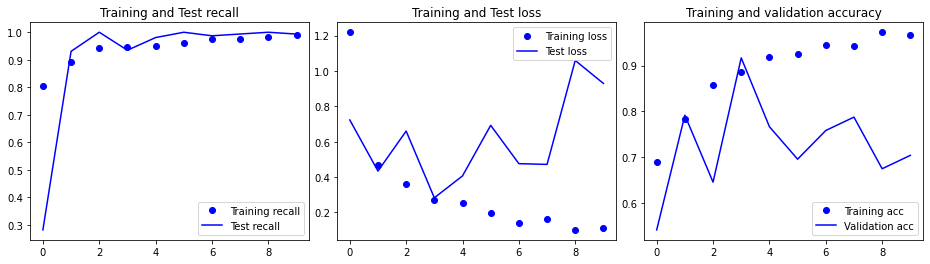

In [81]:
visualize_training_history(base_model_results,recall_num="")

### Visualize comparison of true class balance vs. predictions
The below function renders a horizontal bar chart with two bars, one bar shows the true labels and the other shows the predicted labels. Both the bars are stacked in order to show the class balance of each set of labels.

In [75]:
def viz_class_balance_comparison(y_test,y_pred):
    """
    Takes in two 1d arrays, the true labels and the predicted labels
    creates a dataframe of the class balance of each set 
    plots the class balance as a stacked barchart

    returns the dataframe used to plot therefore...
    displays plot *if* assigned to a variable
    displays plot followed be dataframe if not assigned to a variable
    """

    # get summary stats for test labels
    test_unique, test_counts = np.unique(y_test, return_counts=True)
    pred_unique, pred_counts = np.unique(y_pred, return_counts=True)

    # format summary stats as a dictionary
    balance_comparison_dict = {"Test":test_counts,"Prediction":pred_counts}

    # format dictionary as a dataframe with custom indeces
    balance_comparison_df = pd.DataFrame(balance_comparison_dict,index=["Normal","Pneumonia"])
    
    # plot stacked bar chart
    blues = plt.cm.Blues
    balance_comparison_df.T.plot(kind='barh', stacked=True, color=[blues(0.5), blues(0.4)])
    plt.show()

    return balance_comparison_df


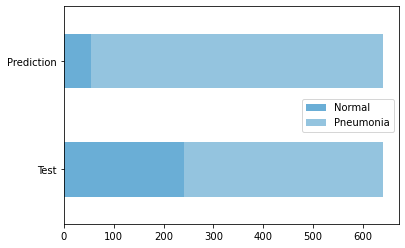

,Test,Prediction
Normal,240,54
Pneumonia,400,586


In [76]:
viz_class_balance_comparison(y_test,y_pred)

### Visualizing the confusion matrix
Below takes the above confusion matrix, normalizes it to show percentages instead of counts and visualizes it as a heatmap.

In [73]:
def viz_confusion_matrix(confusion_matrix_array:np.array):
    """
    Takes in a numpy array (must be 2D, with only 4 elements (i.e. a confusion matrix))
    normalizes each element in the array to be a percentage 
    plots the normalized values as a confusion matrix using matplotlib
    returns no values, uses .show() method to dispaly the figure
    """
    # Confusion matrix as a 2D array
    cm = confusion_matrix_array

    # Normalize the confusion matrix
    cm = np.round(cm/np.sum(cm),2)

    # Create a figure and a subplot
    fig, ax = plt.subplots()

    # Plot the confusion matrix as a heatmap
    im = ax.imshow(cm, cmap='winter',vmin=0,vmax=1)

    # Add labels to the plot
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # add lines between quadrants for more contrast
    ax.axvline(x=0.5, color='k', linestyle='solid', linewidth=3, alpha=0.5)
    ax.axhline(y=0.5, color='k', linestyle='solid', linewidth=3, alpha=0.5)

    # Add a colorbar to the plot
    fig.colorbar(im)

    # Set the tick marks for the x and y axes
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels([0, 1])
    ax.set_yticklabels([0, 1])

    # Loop over the data dimensions and create text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{cm[i, j]:.2f}', ha='center', va='center', color='w')

    # Show the plot
    plt.show()

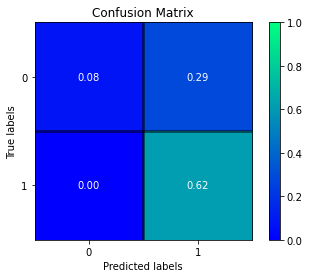

In [74]:
viz_confusion_matrix(base_model_matrix)

The above four functions are packaged in the [project toolkit](project_toolkit.py) file to be import as a module and used throught the following notebook where various iterations of the model will be prototyped and tested (using this para-module). 

# Conlcusion 
The base model succesfully compiles and fits without any errors or warnings. The model outputs can be easily evaluated for classification quality using the above functions. The model also performs decently for a baseline model. I will continue tuning and optimizing thhe model in the [modeling notebook](/PROJECT-2/modeling.ipynb), there I will experiment with various architectures, training protocolls, and other techniques to adapt the model for its unique and specific purpose.